In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib as plt
import matplotlib.pyplot

In [2]:
data = pd.read_csv('Data.csv')
# Remove universities with identical names before setting index to name
data.drop_duplicates(subset="instnm",inplace=True)
data.set_index("instnm",inplace=True)

In [3]:
r2_min = 0.85 # Limit for determining linearity

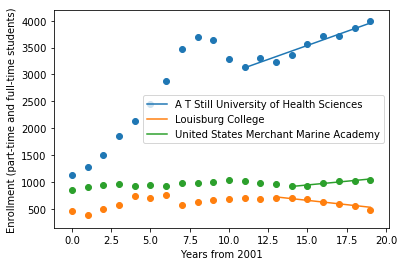

In [4]:
# Multiple formats used in column names- save all fiscal years to enrollment DataFrame.
enroll_col_names = ["Grand total (EF{:}  All students total)".format(i) for i in range(2001,2004)] + ["Grand total (EF{:}_RV  All students total)".format(i) for i in range(2004,2019)] + ["Grand total (EF{:}  All students total)".format(i) for i in range(2019,2021)]
enrollment_list = pd.DataFrame(data[enroll_col_names])
enrollment_list.dropna(inplace=True)
# Ignore schools that had less than 200 enrollment in 2001 so that larger schools are represented
enrollment_list = enrollment_list[enrollment_list["Grand total (EF2001  All students total)"]>=200]
# Create DataFrame of expected 2020 enrollments
enroll_project = pd.DataFrame(enrollment_list["Grand total (EF2020  All students total)"])
enroll_project["Projected 2020 enrollment"] = 0
for i in enrollment_list.index:
    # Start at fourth point from the end so that there are at least four points available, then search more points
    # to determine when the data stops being linear.
    for j in reversed(range(0,len(enrollment_list.loc[i])-4)):
        # Find out when r^2 value is invalid (data not linear)
        year_range = [n for n in range(j,len(enrollment_list.loc[i])-1)]
        cor = np.corrcoef(year_range, enrollment_list.loc[i][year_range])
        r2 = cor[0,1]**2
        if r2 < r2_min:
            # Remove point that leads to bad r2 value
            year_range = year_range[1:]
            break
    if (len(year_range) == 3):
        # Remove enrollments without clear trends
        enrollment_list.drop(index=i, inplace=True)
        continue;
    p = np.polyfit(year_range, enrollment_list.loc[i][year_range],1)
    enroll_project["Projected 2020 enrollment"].loc[i] = p[0] * 19 + p[1]
    # plot a few random lines
    if (i == enrollment_list.index[0]) or (i == enrollment_list.index[500]) or (i == enrollment_list.index[1000]):
        plt.pyplot.plot(range(year_range[0],20),range(year_range[0],20)*p[0]+p[1])
        plt.pyplot.scatter(range(0,20),enrollment_list.loc[i])
        plt.pyplot.xlabel("Years from 2001")
        plt.pyplot.ylabel("Enrollment (part-time and full-time students)")
plt.pyplot.legend([enrollment_list.index[0],enrollment_list.index[500],enrollment_list.index[1000]])
enroll_diff_frac = (enroll_project["Grand total (EF2020  All students total)"] - enroll_project["Projected 2020 enrollment"])/enroll_project["Grand total (EF2020  All students total)"]

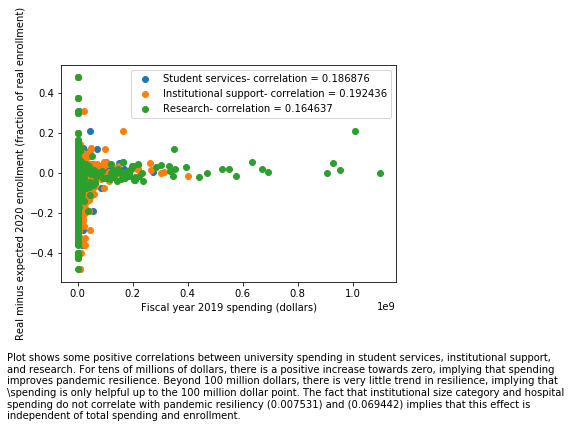

In [5]:
# Drop outliers from enroll difference- came from errors in the forcasting
enroll_diff_frac = enroll_diff_frac[abs(enroll_diff_frac)<0.5]
corr_df = pd.DataFrame(data.loc[enroll_diff_frac.index])
corr_df["Enroll difference"] = enroll_diff_frac
corr_df.dropna(inplace=True,subset=["Enroll difference","Student-to-faculty ratio (EF2019D)","Percent of full-time first-time undergraduates awarded any financial aid (SFA1920)"])

# Plot spending vs. 
plt.pyplot.scatter(corr_df["Student services - Current year total (F1920_F1A)"],corr_df["Enroll difference"])
plt.pyplot.scatter(corr_df["Institutional support - Current year total (F1920_F1A)"],corr_df["Enroll difference"])
plt.pyplot.scatter(corr_df["Research - Current year total (F1920_F1A)"],corr_df["Enroll difference"])
plt.pyplot.xlabel("Fiscal year 2019 spending (dollars)")
plt.pyplot.ylabel("Real minus expected 2020 enrollment (fraction of real enrollment)")
plt.pyplot.legend(["Student services- correlation = 0.186876","Institutional support- correlation = 0.192436","Research- correlation = 0.164637"])
plt.pyplot.figtext(0.0, -.35, "Plot shows some positive correlations between university spending in student services, institutional support,\nand research."+
                   " For tens of millions of dollars, there is a positive increase towards zero, implying that"
                   " spending \nimproves pandemic resilience. Beyond 100 million dollars, there is very little"
                   " trend in resilience, implying that\n\spending is only helpful up to the 100 million dollar point."
                   " The fact that institutional size category and hospital\nspending do not correlate with pandemic"
                   " resiliency (0.007531) and (0.069442) implies that this effect is\nindependent of total spending"
                   " and enrollment.")
plt.pyplot.savefig("spending.png")

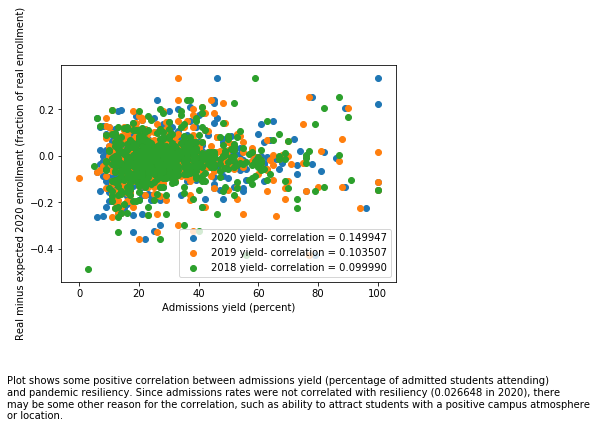

In [6]:
plt.pyplot.scatter(corr_df["Admissions yield - total (DRVADM2020)"],corr_df["Enroll difference"])
plt.pyplot.scatter(corr_df["Admissions yield - total (DRVADM2019_RV)"],corr_df["Enroll difference"])
plt.pyplot.scatter(corr_df["Admissions yield - total (DRVADM2018_RV)"],corr_df["Enroll difference"])
plt.pyplot.legend(["2020 yield- correlation = 0.149947","2019 yield- correlation = 0.103507","2018 yield- correlation = 0.099990"])
plt.pyplot.xlabel("Admissions yield (percent)")
plt.pyplot.ylabel("Real minus expected 2020 enrollment (fraction of real enrollment)")
plt.pyplot.figtext(0.0, -.35, "Plot shows some positive correlation between admissions yield (percentage of admitted students"
                              " attending)\nand pandemic resiliency. Since admissions rates were not correlated with"
                              " resiliency (0.026648 in 2020), there\nmay be some other reason for the correlation, such as"
                              " ability to attract students with a positive campus atmosphere\nor location.")
plt.pyplot.savefig("yield.png")

In [7]:
corr_df.corr()["Enroll difference"].to_string()

'Grand total (GR2020  4-year institutions  Adjusted cohort (revised cohort minus exclusions))                               0.036581\nAverage net price (income 0-30 000)-students awarded Title IV federal financial aid  2019-20 (SFA1920)                    -0.026391\nAverage net price (income 30 001-48 000)-students awarded Title IV federal financial aid  2019-20 (SFA1920)               -0.049141\nAverage net price (income 48 001-75 000)-students awarded Title IV federal financial aid  2019-20 (SFA1920)               -0.066232\nAverage net price (income 75 001-110 000)-students awarded Title IV federal financial aid  2019-20 (SFA1920)              -0.105404\nAverage net price (income over 110 000)-students awarded Title IV federal financial aid  2019-20 (SFA1920)                -0.151511\nPercent of full-time first-time undergraduates awarded any financial aid (SFA1920)                                         0.130428\nPercent of full-time first-time undergraduates awarded federal  stat